In [ ]:
# Stage 0: Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, f1_score, 
    classification_report, precision_recall_curve, roc_curve, brier_score_loss
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import sklearn, imblearn
import joblib
import json

RANDOM_STATE = 42

print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)
print("imblearn:", imblearn.__version__)


Shape: (7000, 10)
Class balance:
Exited
0    0.796286
1    0.203714
Name: proportion, dtype: float64


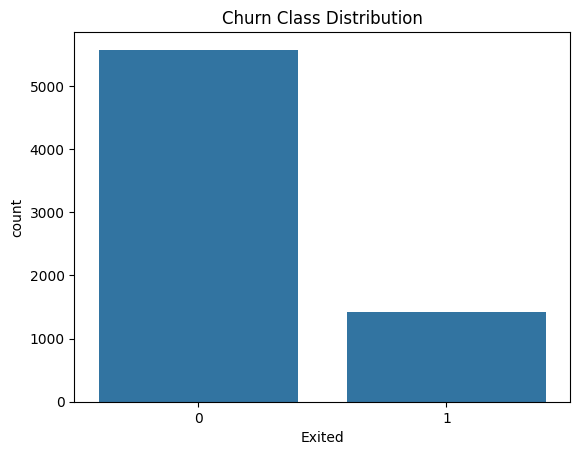

In [ ]:
# Stage 1: Load, Split and Inspect Data

df = pd.read_csv("Bank_Churn.csv")

# Drop leakage-prone ID columns
drop_cols = ["RowNumber", "CustomerId", "Surname"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Target
y = df["Exited"]
X = df.drop(columns=["Exited"])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print("Shape:", X_train.shape)
print("Class balance:")
print(y_train.value_counts(normalize=True))

# Visualize class imbalance
sns.countplot(x=y_train)
plt.title("Churn Class Distribution")
plt.show()


In [5]:
# Stage 2: Preprocessing Setup

# Identify column types
num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(exclude="number").columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Preprocessing: scale numbers, encode categoricals
pre = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])


Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical columns: ['Geography', 'Gender']


In [6]:
# Stage 3: Build Pipeline 

# Logistic Regression pipeline
pipe_lr = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE))
])

# Random Forest pipeline
pipe_rf = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)),
    ("model", RandomForestClassifier(
        n_estimators=300,         # number of trees
        max_depth=None,          # let trees grow deep
        class_weight="balanced", # handle imbalance
        n_jobs=-1,               # parallelize
        random_state=RANDOM_STATE
    ))
])


In [7]:
# Stage 4b: Compare Models Cross-Validation & Metrics

models = {"LogisticRegression": pipe_lr, "RandomForest": pipe_rf}
results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "roc_auc": "roc_auc",
    "pr_auc": "average_precision",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}

for name, pipe in models.items():
    cvres = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
    results[name] = pd.DataFrame(cvres).mean()

comparison = pd.DataFrame(results).T
comparison


,fit_time,score_time,test_roc_auc,test_pr_auc,test_f1,test_precision,test_recall
LogisticRegression,0.103550,0.039431,0.757052,0.440292,0.487288,0.380066,0.679536
RandomForest,1.530488,0.216046,0.844613,0.637946,0.561980,0.677751,0.480353


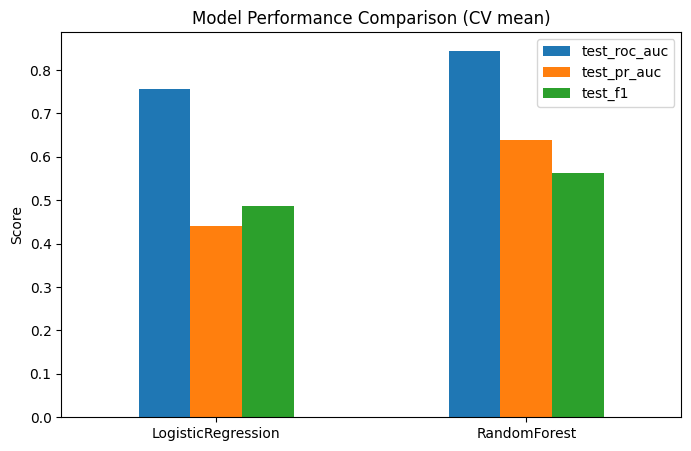

In [8]:
# Stage 5b: Visualize Model Comparison

comparison_plot = comparison[["test_roc_auc", "test_pr_auc", "test_f1"]]

comparison_plot.plot(kind="bar", figsize=(8,5))
plt.ylabel("Score")
plt.title("Model Performance Comparison (CV mean)")
plt.xticks(rotation=0)
plt.show()


In [9]:
## Hyperparameter Search

In [23]:
from sklearn.model_selection import GridSearchCV

# Define grids
param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l2"],   # l1 possible if using saga solver, causing error
    "model__solver": ["lbfgs", "saga"]
}

param_grid_rf = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 5, 10, 20],
    "model__min_samples_split": [2, 5],
    "model__max_features": ["sqrt", "log2"]
}


In [12]:
# Example: Random Forest grid search
grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("Best params RF:", grid_rf.best_params_)
print("Best ROC-AUC RF:", grid_rf.best_score_)

Best params RF: {'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best ROC-AUC RF: 0.8500901993597056


In [24]:
# Example: Logistic Regression grid search
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)

print("Best params LR:", grid_lr.best_params_)
print("Best ROC-AUC LR:", grid_lr.best_score_)

Best params LR: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best ROC-AUC LR: 0.7572778456266425


In [25]:
## Stage 7 – Probability Calibration & Thresholding

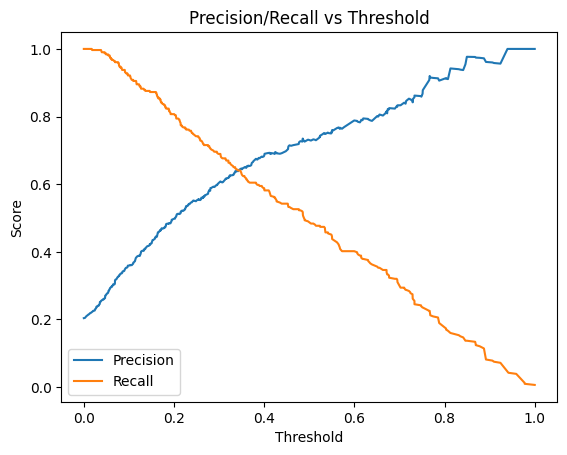

In [29]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve

# Wrap the best RF with calibration
cal_rf = CalibratedClassifierCV(grid_rf.best_estimator_, method="isotonic", cv=3)
cal_rf.fit(X_train, y_train)

# Plot threshold tuning (PR curve)
probs_rf = cal_rf.predict_proba(X_val)[:,1]
prec, rec, thresh = precision_recall_curve(y_val, probs_rf)

plt.plot(thresh, prec[:-1], label="Precision")
plt.plot(thresh, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold")
plt.legend()
plt.show()


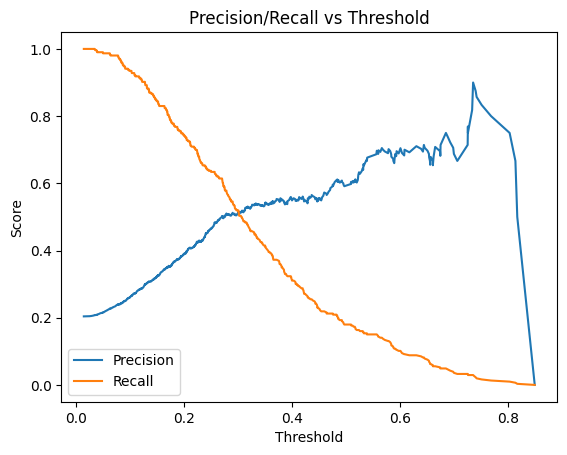

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# # Suppose we already tuned LogisticRegression
# best_lr = LogisticRegression(max_iter=1000, class_weight="balanced")

# Calibration step (sigmoid usually better for LR, isotonic for tree models)
cal_lr = CalibratedClassifierCV(grid_lr.best_estimator_, method="sigmoid", cv=3)
cal_lr.fit(X_train, y_train)

# Plot threshold tuning (PR curve)
probs_lr = cal_lr.predict_proba(X_val)[:, 1]
prec, rec, thresh = precision_recall_curve(y_val, probs_lr)

plt.plot(thresh, prec[:-1], label="Precision")
plt.plot(thresh, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold")
plt.legend()
plt.show()

In [31]:
# Stage 8 — Evaluation on Validation

In [37]:
def evaluate_model(name, model, X, y):
    probs = model.predict_proba(X)[:,1]
    preds = model.predict(X)

    auc = roc_auc_score(y, probs)
    ap = average_precision_score(y, probs)
    brier = brier_score_loss(y, probs)

    print(f"\n{name}")
    print(f"AUC: {auc:.3f} | AP: {ap:.3f} | Brier: {brier:.3f}")
    print(confusion_matrix(y, preds))
    print(classification_report(y, preds))

# Evaluate
evaluate_model("Calibrated LR", cal_lr, X_val, y_val)
evaluate_model("Calibrated RF", cal_rf, X_val, y_val)



Calibrated LR
AUC: 0.790 | AP: 0.495 | Brier: 0.133
[[1157   37]
 [ 251   55]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1194
           1       0.60      0.18      0.28       306

    accuracy                           0.81      1500
   macro avg       0.71      0.57      0.58      1500
weighted avg       0.78      0.81      0.76      1500


Calibrated RF
AUC: 0.881 | AP: 0.700 | Brier: 0.101
[[1139   55]
 [ 158  148]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1194
           1       0.73      0.48      0.58       306

    accuracy                           0.86      1500
   macro avg       0.80      0.72      0.75      1500
weighted avg       0.85      0.86      0.85      1500



In [38]:
## Stage 8 – Export Pipeline

In [39]:
import joblib

# Save
joblib.dump(cal_rf, "rf_churn_pipeline.pkl")
joblib.dump(cal_lr, "lr_churn_pipeline.pkl")


['lr_churn_pipeline.pkl']

In [40]:
## Stage 9: Inference Demo

In [41]:
import joblib
import pandas as pd

# Load pipeline back
loaded_rf_pipe = joblib.load("rf_churn_pipeline.pkl")
loaded_lr_pipe = joblib.load("lr_churn_pipeline.pkl")

# Example: one new customer
new_customer = pd.DataFrame([{
    "CreditScore": 600,
    "Geography": "France",
    "Gender": "Female",
    "Age": 42,
    "Tenure": 3,
    "Balance": 50000,
    "NumOfProducts": 2,
    "HasCrCard": 1,
    "IsActiveMember": 1,
    "EstimatedSalary": 60000
}])

# Predict class
y_new_rf = loaded_rf_pipe.predict(new_customer)
y_new_lr = loaded_lr_pipe.predict(new_customer)

# Predict probabilities
y_prob_rf = loaded_rf_pipe.predict_proba(new_customer)
y_prob_lr = loaded_lr_pipe.predict_proba(new_customer)

print("Predicted class:", y_new_rf)
print("Predicted probabilities:", y_prob_rf)

print("Predicted class:", y_new_lr)
print("Predicted probabilities:", y_prob_lr)

Predicted class: [0]
Predicted probabilities: [[0.84937862 0.15062138]]
Predicted class: [0]
Predicted probabilities: [[0.85730823 0.14269177]]


In [54]:
# Pick best model (example: RF)
final_model = cal_rf

# Test prediction
sample = X_test.iloc[:5]

print("Expected:")
print(y_test.iloc[:5])

print("Sample predictions:")
print(final_model.predict(sample))
print(final_model.predict_proba(sample))

# Save model
joblib.dump(final_model, "churn_model.pkl")

# Save schema + metadata
metadata = {
    "features": list(X.columns),
    "numeric_features": num_cols,
    "categorical_features": cat_cols,
    "model_type": "RandomForest + Calibration",
    "hyperparams": grid_rf.best_params_
}
with open("model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)


Expected:
9161    0
8692    0
4616    0
5818    0
9093    0
Name: Exited, dtype: int64
Sample predictions:
[0 0 0 0 0]
[[0.83133112 0.16866888]
 [0.98638262 0.01361738]
 [0.93797031 0.06202969]
 [0.91481599 0.08518401]
 [0.83898903 0.16101097]]
